In [1]:
import geopandas as gpd
import vaex
import pandas as pd
import glob
import os

In [2]:

## Carregando Quadras Fiscais para espacializar o lcto do IPTU

gdf_quadras = gpd.read_file('zip://dados/SIRGAS_SHP_quadraMDSF.zip!SIRGAS_SHP_quadraMDSF/SIRGAS_SHP_quadraMDSF.shp')
gdf_quadras = gdf_quadras.set_crs(epsg=31983)
gdf_quadras = gdf_quadras[gdf_quadras.qd_tipo == 'F']
gdf_quadras = gdf_quadras.dissolve(['qd_setor', 'qd_fiscal']).reset_index()

In [3]:
## Relacionando a quadra ao distrito para agregação espacial

gdf_distritos = gpd.read_file('dados/SIRGAS_GPKG_distrito.gpkg')
gdf_quadras_distritos = gdf_quadras.sjoin(gdf_distritos, how='left', predicate='intersects')
gdf_quadras_distritos.drop('index_right', axis=1, inplace=True)

df_quadras_distritos = gdf_quadras_distritos.loc[:, ['qd_setor', 'qd_fiscal', 'ds_codigo', 'ds_nome', 'ds_cd_sub', 'ds_subpref']]
df_quadras_distritos.loc[:, ['sq']] = df_quadras_distritos.qd_setor + df_quadras_distritos.qd_fiscal
df_quadras_distritos.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [4]:
df_dim_veg = vaex.open('resultados/dimensoes_vegetacao.feather')

In [6]:
df_quadras_distritos

,qd_setor,qd_fiscal,ds_codigo,ds_nome,ds_cd_sub,ds_subpref,sq
0,001,003,9,BOM RETIRO,09,SE,001003
1,001,004,9,BOM RETIRO,09,SE,001004
2,001,005,9,BOM RETIRO,09,SE,001005
3,001,006,9,BOM RETIRO,09,SE,001006
4,001,007,9,BOM RETIRO,09,SE,001007
...,...,...,...,...,...,...,...
46011,310,116,38,JABAQUARA,15,JABAQUARA,310116
46012,310,117,38,JABAQUARA,15,JABAQUARA,310117
46013,310,118,38,JABAQUARA,15,JABAQUARA,310118
46014,310,119,38,JABAQUARA,15,JABAQUARA,310119


In [7]:
# Carregando IPTU 2022
df = vaex.open('dados/IPTU_2022.hdf5')
df.shape

(3580061, 29)

In [8]:
# Pré-processamento dos dados do IPTU
df.setor = df['NUMERO DO CONTRIBUINTE'].str.slice(0,3)
df.quadra = df['NUMERO DO CONTRIBUINTE'].str.slice(3,6)
df.fillna(value='00-0', column_names=['NUMERO DO CONDOMINIO'], inplace=True)
df.fillna(value=1., column_names=['FRACAO IDEAL'], inplace=True)
df.fillna(value=0., column_names=['AREA CONSTRUIDA', 'AREA OCUPADA', 'AREA DO TERRENO'], inplace=True)
df.sqlc = df.func.where(df['NUMERO DO CONDOMINIO'] == '00-0',
                                df['NUMERO DO CONTRIBUINTE'].str.slice(0, 10) + '00',
                                df['NUMERO DO CONTRIBUINTE'].str.slice(0, 6) + '0000' + df['NUMERO DO CONDOMINIO'].str.slice(0, 2))
df['sq'] = df.setor + df.quadra
df['sqlc'] = df.sqlc
df_sqlc_ac = df.groupby('sqlc', agg={'area_contruida_total': vaex.agg.sum('AREA CONSTRUIDA')})
df = df.join(df_sqlc_ac, on='sqlc')
df['fracao_ideal'] = df.func.where(df['FRACAO IDEAL'] == 0.,  
                                            df['AREA CONSTRUIDA'] / df['area_contruida_total'],
                                            df['FRACAO IDEAL'])
df['ca'] = (df['AREA CONSTRUIDA'] / df['fracao_ideal']) / df['AREA DO TERRENO']
df['to'] = df['AREA OCUPADA'] / df['AREA DO TERRENO']

df['valor_terreno'] = df['fracao_ideal'] * df['VALOR DO M2 DO TERRENO'] * df['AREA DO TERRENO']
df['valor_construcao'] = df['VALOR DO M2 DE CONSTRUCAO'] * df['AREA CONSTRUIDA']

In [10]:
df['fracao_ideal'].sum()

array(1659954.82717382)

In [11]:
# Relacionando o IPTU a agregação por Distrito
df = df.join(vaex.from_pandas(df_quadras_distritos), on='sq', how='left',  
            allow_duplication=True, inplace=False)

In [12]:
df.shape

(3618007, 43)

In [13]:
df = df.join(df_dim_veg, on='sqlc', how='left', allow_duplication=True, inplace=True)

In [14]:
print(df.column_names)

['NUMERO DO CONTRIBUINTE', 'ANO DO EXERCICIO', 'NUMERO DA NL', 'DATA DO CADASTRAMENTO', '__NUMERO DO CONDOMINIO', 'CODLOG DO IMOVEL', 'NOME DE LOGRADOURO DO IMOVEL', 'NUMERO DO IMOVEL', 'COMPLEMENTO DO IMOVEL', 'BAIRRO DO IMOVEL', 'REFERENCIA DO IMOVEL', 'CEP DO IMOVEL', 'QUANTIDADE DE ESQUINAS FRENTES', '__FRACAO IDEAL', '__AREA DO TERRENO', '__AREA CONSTRUIDA', '__AREA OCUPADA', 'VALOR DO M2 DO TERRENO', 'VALOR DO M2 DE CONSTRUCAO', 'ANO DA CONSTRUCAO CORRIGIDO', 'QUANTIDADE DE PAVIMENTOS', 'TESTADA PARA CALCULO', 'TIPO DE USO DO IMOVEL', 'TIPO DE PADRAO DA CONSTRUCAO', 'TIPO DE TERRENO', 'FATOR DE OBSOLESCENCIA', 'ANO DE INICIO DA VIDA DO CONTRIBUINTE', 'MES DE INICIO DA VIDA DO CONTRIBUINTE', 'FASE DO CONTRIBUINTE', 'area_contruida_total', 'qd_setor', 'qd_fiscal', 'ds_codigo', 'ds_nome', 'ds_cd_sub', 'ds_subpref', 'NUMERO DO CONDOMINIO', 'FRACAO IDEAL', 'AREA CONSTRUIDA', 'AREA OCUPADA', 'AREA DO TERRENO', 'sq', 'sqlc', 'fracao_ideal', 'ca', 'to', 'valor_terreno', 'valor_construcao

In [15]:
df.shape

(3619080, 47)

In [15]:
# df['TIPO DE USO DO IMOVEL'].isin(tipo_de_uso)

In [16]:
# df_iptu['TIPO DE USO DO IMOVEL'].value_counts()

## FILTRAR PARA FRACAO IDEAL == 1

df = df[df['fracao_ideal'] == 1]

## FILTRAR SEGUNDO OS CRITERIOS de 'TIPO DE USO DO IMOVEL'

tipo_de_uso = [
    'Residência',
    'Residência coletiva, exclusive cortiço (mais de uma residência no lote)',
    'Residência e outro uso (predominância residencial)'
]

df = df[df['TIPO DE USO DO IMOVEL'].isin(tipo_de_uso)]

## FILTRAR POR QUANTIDADE DE PAVIMENTOS

df = df[df['QUANTIDADE DE PAVIMENTOS'] <= 3]

## Existem alguns parametros interessantes para qualificá-las
atributos = [
    'AREA DO TERRENO',
    'VALOR DO M2 DO TERRENO',
    'VALOR DO M2 DE CONSTRUCAO',
    'ANO DA CONSTRUCAO CORRIGIDO',
    'TESTADA PARA CALCULO',
    'FATOR DE OBSOLESCENCIA',
    # 'area_contruida_total', 
    'ca', 
    'to', 
    # 'valor_terreno', 
    # 'valor_construcao',
    'media_veg_lote',
    'media_veg_100m',
    'media_veg_1000m'
]

## Existem pouco mais de 8000 terrenos maiores de 1000 metros além dos outros criterios

df = df[df['AREA DO TERRENO'] <= 1000]

# Além dos dados LiDAR de Vegetação e Morfologia

# Além disso temos os dados sócio-economicos do CENSO

## Que tal?

In [17]:
df.fillna(value=0., column_names=['media_veg_lote', 'media_veg_100m','media_veg_1000m'], inplace=True)

/home/fernando/miniconda3/envs/geo/lib/python3.10/site-packages/vaex/arrow/numpy_dispatch.py:72: RuntimeWarning: invalid value encountered in true_divide
  result_data = op['op'](a_data, b_data)


#,NUMERO DO CONTRIBUINTE,ANO DO EXERCICIO,NUMERO DA NL,DATA DO CADASTRAMENTO,CODLOG DO IMOVEL,NOME DE LOGRADOURO DO IMOVEL,NUMERO DO IMOVEL,COMPLEMENTO DO IMOVEL,BAIRRO DO IMOVEL,REFERENCIA DO IMOVEL,CEP DO IMOVEL,QUANTIDADE DE ESQUINAS FRENTES,VALOR DO M2 DO TERRENO,VALOR DO M2 DE CONSTRUCAO,ANO DA CONSTRUCAO CORRIGIDO,QUANTIDADE DE PAVIMENTOS,TESTADA PARA CALCULO,TIPO DE USO DO IMOVEL,TIPO DE PADRAO DA CONSTRUCAO,TIPO DE TERRENO,FATOR DE OBSOLESCENCIA,ANO DE INICIO DA VIDA DO CONTRIBUINTE,MES DE INICIO DA VIDA DO CONTRIBUINTE,FASE DO CONTRIBUINTE,area_contruida_total,qd_setor,qd_fiscal,ds_codigo,ds_nome,ds_cd_sub,ds_subpref,NUMERO DO CONDOMINIO,FRACAO IDEAL,AREA CONSTRUIDA,AREA OCUPADA,AREA DO TERRENO,sq,sqlc,fracao_ideal,ca,to,valor_terreno,valor_construcao,index,media_veg_lote,media_veg_100m,media_veg_1000m
0,0010030023-5,2022,1,2022-01-01 00:00:00.000000000,06156-5,R DUTRA RODRIGUES,89.0,--,SANTA IFIGENIA,--,01105-010,0,2032.0,2473.0,1924,2,5.9,Residência e outro uso (predominância residencial),Residencial horizontal - padrão C,Normal,0.2,1963,1,0,200,001,003,9,BOM RETIRO,09,SE,00-0,1.0,200,100,150,001003,001003002300,1.0,1.3333333333333333,0.6666666666666666,304800.0,494600.0,4712,0.3988439306358382,0.0,0.0
1,0010030028-6,2022,1,2022-01-01 00:00:00.000000000,06156-5,R DUTRA RODRIGUES,155.0,--,--,--,01105-010,0,2032.0,2387.0,1934,1,6.0,Residência,Residencial horizontal - padrão B,Normal,0.2,1963,1,0,100,001,003,9,BOM RETIRO,09,SE,00-0,1.0,100,100,168,001003,001003002800,1.0,0.5952380952380952,0.5952380952380952,341376.0,238700.0,2653,0.0,0.0,0.0
2,0010030029-4,2022,1,2022-01-01 00:00:00.000000000,06156-5,R DUTRA RODRIGUES,165.0,--,--,--,01105-010,0,2032.0,2387.0,1924,1,5.65,Residência,Residencial horizontal - padrão B,Normal,0.2,1963,1,0,100,001,003,9,BOM RETIRO,09,SE,00-0,1.0,100,100,150,001003,001003002900,1.0,0.6666666666666666,0.6666666666666666,304800.0,238700.0,1839,0.0,0.0,0.0
3,0010030030-8,2022,1,2022-01-01 00:00:00.000000000,06156-5,R DUTRA RODRIGUES,167.0,--,LUZ,--,01105-010,0,2032.0,2473.0,1934,2,6.1,Residência,Residencial horizontal - padrão C,Normal,0.2,1963,1,0,300,001,003,9,BOM RETIRO,09,SE,00-0,1.0,300,129,162,001003,001003003000,1.0,1.8518518518518519,0.7962962962962963,329184.0,741900.0,4241,0.0,0.0,0.0
4,0010030045-6,2022,1,2022-01-01 00:00:00.000000000,10485-0,R JOAO TEODORO,70.0,CS 3,LUZ,--,01105-000,0,2006.0,2126.0,1934,1,8.0,Residência,Residencial horizontal - padrão A,Terreno interno,0.2,1963,1,0,60,001,003,9,BOM RETIRO,09,SE,00-0,1.0,60,60,80,001003,001003004500,1.0,0.75,0.75,160480.0,127560.0,1835,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,315,146",1030250089-7,2022,1,2022-01-01 00:00:00.000000000,71817-3,R JOSE JOAQUIM ESTEVES,420.0,428,--,JD SAO LUIZ,05813-030,0,357.0,1774.0,1970,1,10.0,"'Residência coletiva, exclusive cortiço (mais de...",Residencial horizontal - padrão C,Normal,0.35,1982,1,0,100,103,025,46,JARDIM SAO LUIS,18,M'BOI MIRIM,00-0,1.0,100,100,300,103025,103025008900,1.0,0.3333333333333333,0.3333333333333333,107100.0,177400.0,26630,1.5658105939004816,1.897271268057785,4.278491171749598
"1,315,147",1030250090-0,2022,1,2022-01-01 00:00:00.000000000,71817-3,R JOSE JOAQUIM ESTEVES,414.0,416,--,JD SAO LUIZ,05813-030,0,357.0,1686.0,1993,1,10.0,Residência e outro uso (predominância residencial),Residencial horizontal - padrão B,Normal,0.5,1982,1,0,130,103,025,46,JARDIM SAO LUIS,18,M'BOI MIRIM,00-0,1.0,130,130,300,103025,103025009000,1.0,0.43333333333333335,0.43333333333333335,107100.0,219180.0,26631,0.8646748681898067,1.0202108963093146,4.0
"1,315,148",2580140088-3,2022,1,2022-01-01 00:00:00.000000000,23182-7,R ANTONIO ALFREDO CAMPOS,172.0,--,JD GANHEMBU,--,04814-560,0,685.0,1383.0,2013,2,5.0,Residência e outro uso (predominância residencial),Residencial horizontal - padrão C,Normal,0.93,2018,5,0,234,258,014,23,CIDADE DUTRA,19,

In [18]:
df.shape

(1315151, 47)

In [19]:
df_iptu = df[['ds_codigo', 'ds_nome'] + atributos].to_pandas_df()

In [20]:
pd.options.display.float_format = '{:.2f}'.format
df_iptu.describe()

,AREA DO TERRENO,VALOR DO M2 DO TERRENO,VALOR DO M2 DE CONSTRUCAO,ANO DA CONSTRUCAO CORRIGIDO,TESTADA PARA CALCULO,FATOR DE OBSOLESCENCIA,ca,to,media_veg_lote,media_veg_100m,media_veg_1000m
count,1315151.00,1315151.00,1315151.00,1315151.00,1315151.00,1315151.00,1315151.00,1315151.00,1315151.00,1315151.00,1315151.00
mean,193.41,1207.67,1604.79,1982.70,8.06,0.45,0.78,0.53,2.25,1.50,1.36
std,114.40,1028.76,375.03,14.11,4.64,0.22,0.43,0.21,4.46,3.17,2.53
min,4.00,88.00,755.00,1800.00,0.00,0.20,0.01,0.00,0.00,0.00,0.00
25%,125.00,651.00,1291.00,1971.00,5.00,0.20,0.46,0.38,0.00,0.00,0.00
50%,157.00,952.00,1686.00,1982.00,7.00,0.44,0.71,0.52,0.14,0.00,0.00
75%,250.00,1363.00,1774.00,1994.00,10.00,0.62,1.02,0.68,2.14,1.00,2.00
max,1000.00,18461.00,3660.00,2021.00,1427.00,0.99,29.97,1.41,48.96,32.00,25.00


In [21]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

In [22]:
df_iptu_outlier = remove_outliers(df_iptu, atributos, 3)

Working on column: AREA DO TERRENO
Working on column: VALOR DO M2 DO TERRENO
Working on column: VALOR DO M2 DE CONSTRUCAO
Working on column: ANO DA CONSTRUCAO CORRIGIDO
Working on column: TESTADA PARA CALCULO
Working on column: FATOR DE OBSOLESCENCIA
Working on column: ca
Working on column: to
Working on column: media_veg_lote
Working on column: media_veg_100m
Working on column: media_veg_1000m


In [23]:
df_iptu_outlier.shape

(1121189, 13)

In [24]:
df_iptu.describe()

,AREA DO TERRENO,VALOR DO M2 DO TERRENO,VALOR DO M2 DE CONSTRUCAO,ANO DA CONSTRUCAO CORRIGIDO,TESTADA PARA CALCULO,FATOR DE OBSOLESCENCIA,ca,to,media_veg_lote,media_veg_100m,media_veg_1000m
count,1315151.00,1315151.00,1315151.00,1315151.00,1315151.00,1315151.00,1315151.00,1315151.00,1315151.00,1315151.00,1315151.00
mean,193.41,1207.67,1604.79,1982.70,8.06,0.45,0.78,0.53,2.25,1.50,1.36
std,114.40,1028.76,375.03,14.11,4.64,0.22,0.43,0.21,4.46,3.17,2.53
min,4.00,88.00,755.00,1800.00,0.00,0.20,0.01,0.00,0.00,0.00,0.00
25%,125.00,651.00,1291.00,1971.00,5.00,0.20,0.46,0.38,0.00,0.00,0.00
50%,157.00,952.00,1686.00,1982.00,7.00,0.44,0.71,0.52,0.14,0.00,0.00
75%,250.00,1363.00,1774.00,1994.00,10.00,0.62,1.02,0.68,2.14,1.00,2.00
max,1000.00,18461.00,3660.00,2021.00,1427.00,0.99,29.97,1.41,48.96,32.00,25.00


In [25]:
df_iptu_outlier.describe()

,AREA DO TERRENO,VALOR DO M2 DO TERRENO,VALOR DO M2 DE CONSTRUCAO,ANO DA CONSTRUCAO CORRIGIDO,TESTADA PARA CALCULO,FATOR DE OBSOLESCENCIA,ca,to,media_veg_lote,media_veg_100m,media_veg_1000m
count,1121189.00,1121189.00,1121189.00,1121189.00,1121189.00,1121189.00,1121189.00,1121189.00,1121189.00,1121189.00,1121189.00
mean,182.66,1108.73,1587.64,1982.68,7.52,0.45,0.77,0.54,1.27,0.68,0.69
std,89.62,680.37,353.64,13.94,3.09,0.22,0.40,0.21,2.53,1.42,1.18
min,4.00,88.00,755.00,1800.00,0.00,0.20,0.02,0.00,0.00,0.00,0.00
25%,125.00,660.00,1291.00,1971.00,5.00,0.20,0.47,0.39,0.00,0.00,0.00
50%,153.00,948.00,1686.00,1982.00,6.92,0.44,0.71,0.53,0.02,0.00,0.00
75%,245.00,1327.00,1774.00,1993.00,10.00,0.60,1.01,0.68,1.26,1.00,1.00
max,536.00,4246.00,2614.00,2021.00,20.64,0.99,2.07,1.10,15.58,9.02,5.96


array([[<AxesSubplot:title={'center':'AREA DO TERRENO'}>,
        <AxesSubplot:title={'center':'VALOR DO M2 DO TERRENO'}>,
        <AxesSubplot:title={'center':'VALOR DO M2 DE CONSTRUCAO'}>],
       [<AxesSubplot:title={'center':'ANO DA CONSTRUCAO CORRIGIDO'}>,
        <AxesSubplot:title={'center':'TESTADA PARA CALCULO'}>,
        <AxesSubplot:title={'center':'FATOR DE OBSOLESCENCIA'}>],
       [<AxesSubplot:title={'center':'ca'}>,
        <AxesSubplot:title={'center':'to'}>,
        <AxesSubplot:title={'center':'media_veg_lote'}>],
       [<AxesSubplot:title={'center':'media_veg_100m'}>,
        <AxesSubplot:title={'center':'media_veg_1000m'}>, <AxesSubplot:>]],
      dtype=object)

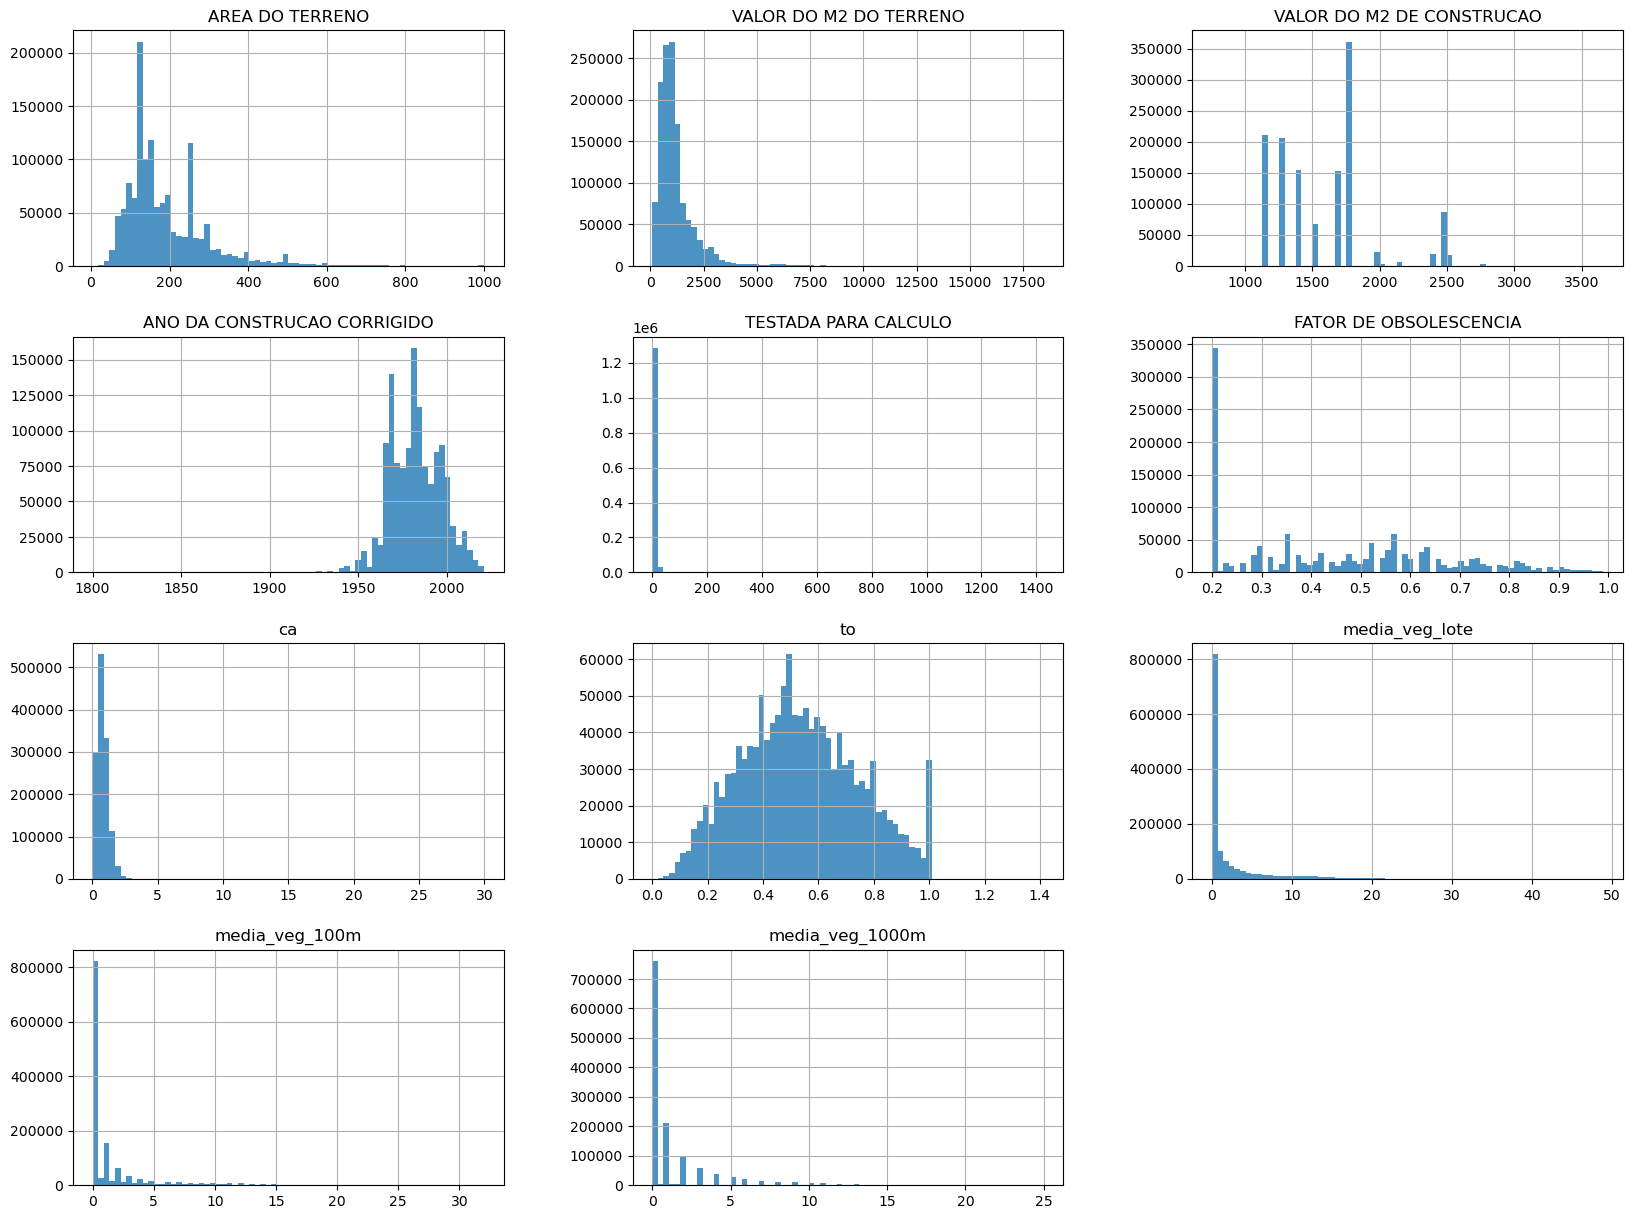

In [26]:
df_iptu.hist(bins=70, figsize=(20, 15), alpha=0.8)

array([[<AxesSubplot:title={'center':'AREA DO TERRENO'}>,
        <AxesSubplot:title={'center':'VALOR DO M2 DO TERRENO'}>,
        <AxesSubplot:title={'center':'VALOR DO M2 DE CONSTRUCAO'}>],
       [<AxesSubplot:title={'center':'ANO DA CONSTRUCAO CORRIGIDO'}>,
        <AxesSubplot:title={'center':'TESTADA PARA CALCULO'}>,
        <AxesSubplot:title={'center':'FATOR DE OBSOLESCENCIA'}>],
       [<AxesSubplot:title={'center':'ca'}>,
        <AxesSubplot:title={'center':'to'}>,
        <AxesSubplot:title={'center':'media_veg_lote'}>],
       [<AxesSubplot:title={'center':'media_veg_100m'}>,
        <AxesSubplot:title={'center':'media_veg_1000m'}>, <AxesSubplot:>]],
      dtype=object)

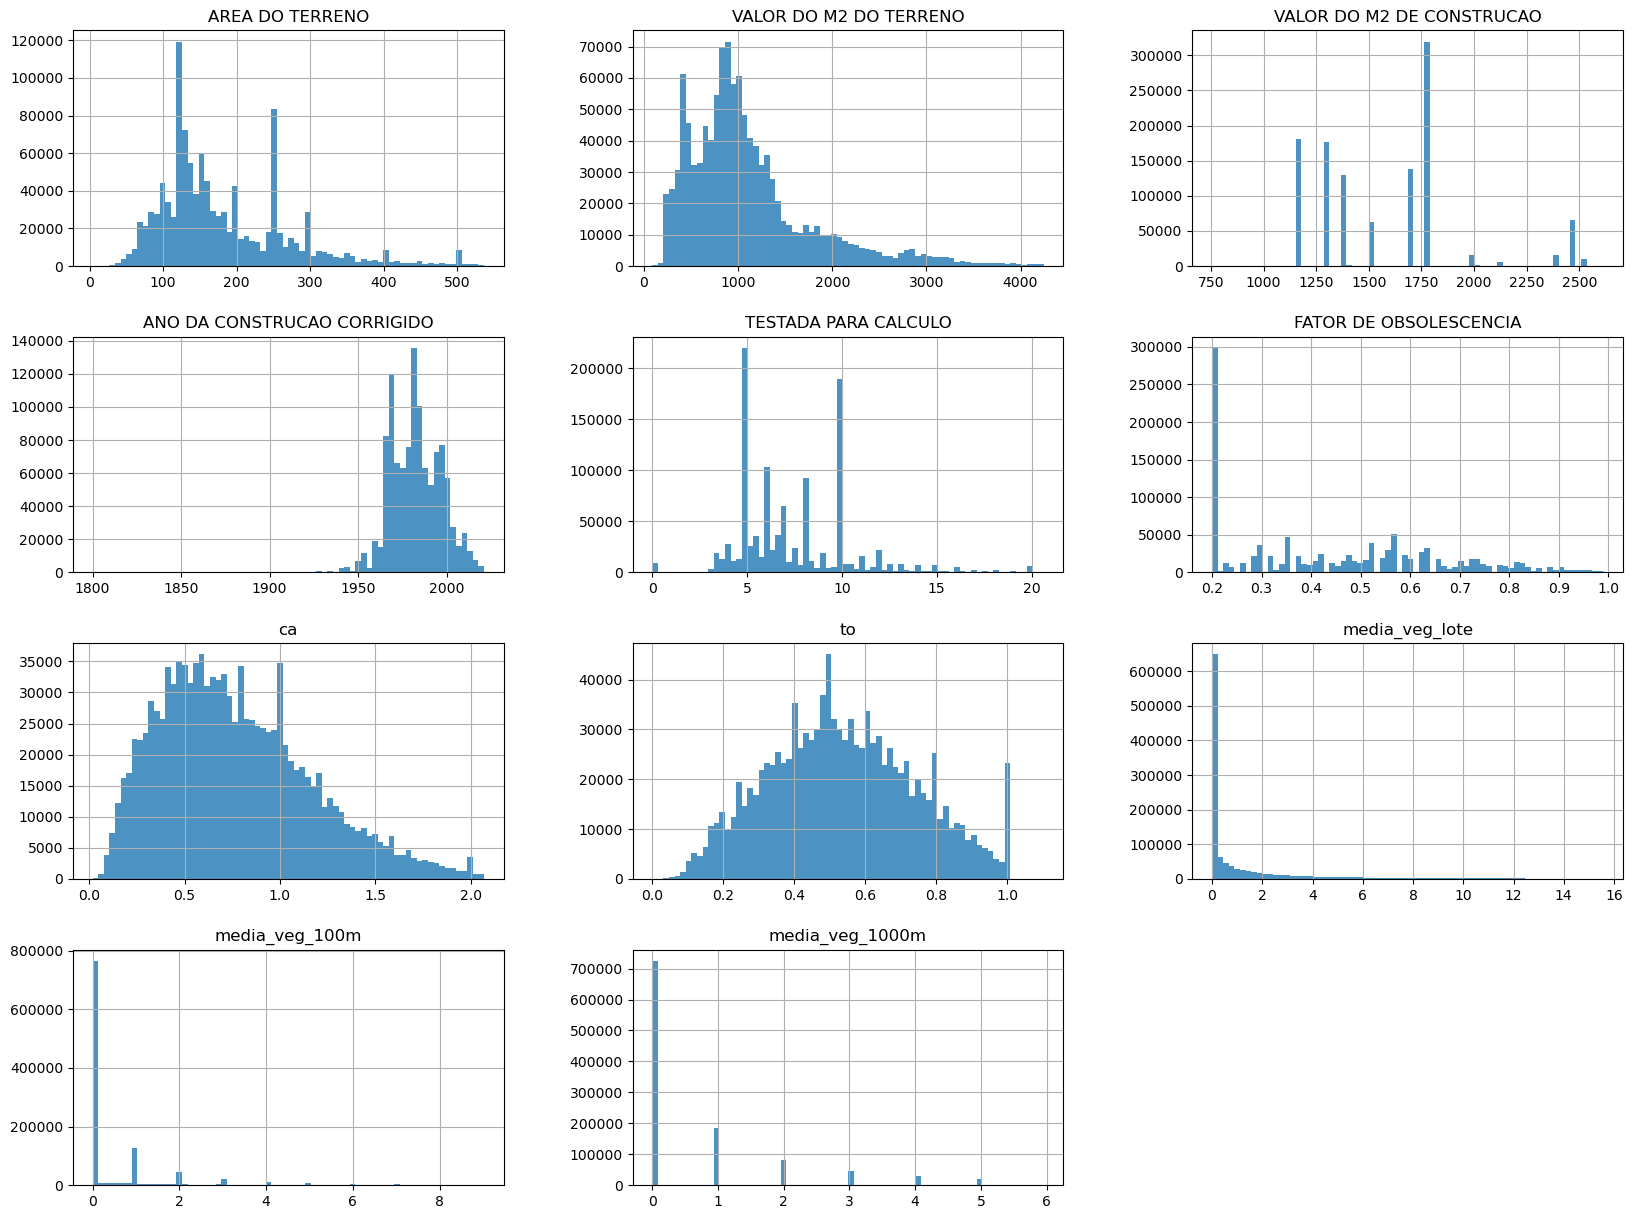

In [27]:
df_iptu_outlier.hist(bins=70, figsize=(20, 15), alpha=0.8)

In [28]:
# df_iptu

In [29]:
df_iptu.drop(['ds_nome'], axis=1).groupby(by='ds_codigo').describe().reset_index()

ds_codigo AREA DO TERRENO                                                   \
                       count   mean    std   min    25%    50%    75%     max   
0          1        16623.00 180.52 104.45 16.00 108.00 152.00 228.00  960.00   
1         10         1762.00  94.71  55.97 21.00  62.00  80.00 105.00  979.00   
2         11        24869.00 175.52  76.75 17.00 129.00 154.00 207.00 1000.00   
3         12        10562.00 244.72 147.47 46.00 135.00 190.00 309.00 1000.00   
4         13        15034.00 208.01  99.74 32.00 128.00 194.00 264.00 1000.00   
..       ...             ...    ...    ...   ...    ...    ...    ...     ...   
91        92        23702.00 153.78  79.57 24.00 100.00 130.00 188.00 1000.00   
92        93        17113.00 200.15 108.19 25.00 125.00 168.00 268.00 1000.00   
93        94        14838.00 203.68 111.47 40.00 125.00 159.00 250.00 1000.00   
94        95        15708.00 201.43 120.16 24.00 125.00 157.00 257.00 1000.00   
95        96        16767.00 196.29  95.09 41.00 132.00 171.00 250.00 1000.00   

   VALOR DO M2 DO TERRENO  ... media_veg_100m       media_veg_1000m            \
                    count  ...            75%   max           count mean  std   
0                16623.00  ...           0.01  7.00        16623.00 0.09 0.28   
1                 1762.00  ...           0.00  5.00         1762.00 0.06 0.24   
2                24869.00  ...           2.00 18.00        24869.00 1.59 2.13   
3                10562.00  ...           5.23 17.45        10562.00 3.71 2.41   
4                15034.00  ...           8.00 20.68        15034.00 3.48 4.07   
..                    ...  ...            ...   ...             ...  ...  ...   
91               23702.00  ...           0.00 24.10        23702.00 0.12 1.08   
92               17113.00  ...           0.00  7.47        17113.00 0.19 0.45   
93               14838.00  ...           2.00 17.74        14838.00 1.48 1.20   
94               15708.00  ...           1.00 12.42        15708.00 0.90 0.99   
95               16767.00  ...           0.00  5.73        16767.00 0.00 0.00   

                              
    min  25%  50%  75%   max  
0  0.00 0.00 0.00 0.00  1.00  
1  0.00 0.00 0.00 0.00  1.00  
2  0.00 0.00 1.00 2.30 10.00  
3  0.00 2.00 3.00 5.96  9.00  
4  0.00 0.00 1.00 7.00 13.00  
..  ...  ...  ...  ...   ...  
91 0.00 0.00 0.00 0.00 13.00  
92 0.00 0.00 0.00 0.00  2.87  
93 0.00 1.00 1.00 2.00  6.00  
94 0.00 0.00 1.00 1.00  6.37  
95 0.00 0.00 0.00 0.00  0.00  

[96 rows x 89 columns]

In [30]:
gdf_estatisticas_por_distrito = gdf_distritos.merge(df_iptu.drop(['ds_nome'], axis=1).groupby(by='ds_codigo').describe().reset_index(), left_on='ds_codigo', right_on='ds_codigo')

/home/fernando/miniconda3/envs/geo/lib/python3.10/site-packages/geopandas/geodataframe.py:1499: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  result = DataFrame.merge(self, *args, **kwargs)
/home/fernando/miniconda3/envs/geo/lib/python3.10/site-packages/geopandas/geodataframe.py:1499: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  result = DataFrame.merge(self, *args, **kwargs)


In [31]:
gdf_estatisticas_por_distrito.columns = gdf_estatisticas_por_distrito.columns.str.join('')

In [32]:
gdf_estatisticas_por_distrito.to_file('resultados/estatisticas-imoveis-residenciais-ate-3-pavimentos.gpkg', driver='GPKG')

In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [34]:
scaler = StandardScaler()

In [35]:
scaler.fit(df_iptu.drop(['ds_codigo', 'ds_nome'], axis=1))

StandardScaler()

In [36]:
X = scaler.transform(df_iptu.drop(['ds_codigo', 'ds_nome'], axis=1))

In [37]:
objective_function=[] 
for i in range(1,11):
    clustering=KMeans(n_clusters=i, init='k-means++')
    clustering.fit(X)
    objective_function.append(clustering.inertia_)

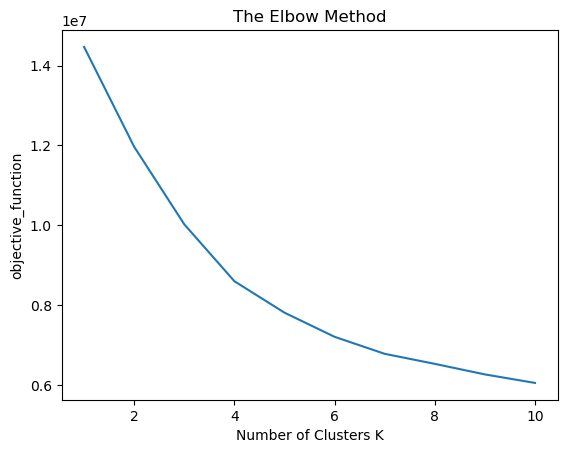

In [38]:
plt.plot(range(1,11),objective_function)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters K')
plt.ylabel('objective_function')
plt.show()

In [39]:
clustering = KMeans(n_clusters=10, init='k-means++')
clustering.fit(X)

KMeans(n_clusters=10)

In [40]:
df_iptu.drop(['ds_codigo', 'ds_nome'], axis=1).columns

Index(['AREA DO TERRENO', 'VALOR DO M2 DO TERRENO',
       'VALOR DO M2 DE CONSTRUCAO', 'ANO DA CONSTRUCAO CORRIGIDO',
       'TESTADA PARA CALCULO', 'FATOR DE OBSOLESCENCIA', 'ca', 'to',
       'media_veg_lote', 'media_veg_100m', 'media_veg_1000m'],
      dtype='object')

In [41]:
label_count = np.unique(clustering.labels_, return_counts=True)

In [42]:
df_centers = pd.DataFrame(scaler.inverse_transform(clustering.cluster_centers_), columns=[df_iptu.drop(['ds_codigo', 'ds_nome'], axis=1).columns])
df_label_qt = pd.DataFrame(label_count[-1], index=label_count[0], columns=['quantidade'])
# pd.DataFrame(label_count[-1], index=label_count[0], columns=['quantidade'])

In [43]:
df_cluster_overview = pd.concat([df_label_qt, df_centers], axis=1)
# df_label_qt.index

In [44]:
df_cluster_overview.columns = df_cluster_overview.columns.str.join('')

In [45]:
df_cluster_overview

,quantidade,AREA DO TERRENO,VALOR DO M2 DO TERRENO,VALOR DO M2 DE CONSTRUCAO,ANO DA CONSTRUCAO CORRIGIDO,TESTADA PARA CALCULO,FATOR DE OBSOLESCENCIA,ca,to,media_veg_lote,media_veg_100m,media_veg_1000m
0,180135,220.79,683.37,1362.38,1992.42,8.63,0.57,0.50,0.39,0.85,0.45,0.62
1,283918,144.61,1228.42,1642.85,1974.59,6.55,0.34,0.85,0.64,0.96,0.45,0.49
2,54733,183.83,939.38,1508.34,1985.83,8.03,0.49,0.81,0.54,16.03,12.93,9.70
3,61987,491.75,1464.98,1846.22,1983.74,19.84,0.52,0.56,0.39,2.01,1.36,1.40
4,22432,195.17,6641.59,2462.53,1965.91,7.54,0.32,1.03,0.59,2.93,1.94,1.85
5,186304,148.86,878.08,1506.46,2000.17,6.49,0.74,0.98,0.61,0.93,0.48,0.65
6,110570,125.69,1068.80,1619.08,1989.76,6.60,0.61,1.57,0.85,1.17,0.61,0.66
7,92876,171.49,2694.06,2413.40,1968.97,6.89,0.34,0.97,0.60,1.79,1.03,1.03
8,237015,229.94,894.06,1410.97,1973.61,8.80,0.24,0.37,0.33,0.96,0.49,0.62
9,85181,193.77,954.38,1505.25,1983.80,8.04,0.44,0.64,0.47,8.97,6.63,5.09


In [46]:
df_iptu

,ds_codigo,ds_nome,AREA DO TERRENO,VALOR DO M2 DO TERRENO,VALOR DO M2 DE CONSTRUCAO,ANO DA CONSTRUCAO CORRIGIDO,TESTADA PARA CALCULO,FATOR DE OBSOLESCENCIA,ca,to,media_veg_lote,media_veg_100m,media_veg_1000m
0,9,BOM RETIRO,150,2032.00,2473.00,1924,5.90,0.20,1.33,0.67,0.40,0.00,0.00
1,9,BOM RETIRO,168,2032.00,2387.00,1934,6.00,0.20,0.60,0.60,0.00,0.00,0.00
2,9,BOM RETIRO,150,2032.00,2387.00,1924,5.65,0.20,0.67,0.67,0.00,0.00,0.00
3,9,BOM RETIRO,162,2032.00,2473.00,1934,6.10,0.20,1.85,0.80,0.00,0.00,0.00
4,9,BOM RETIRO,80,2006.00,2126.00,1934,8.00,0.20,0.75,0.75,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315146,46,JARDIM SAO LUIS,300,357.00,1774.00,1970,10.00,0.35,0.33,0.33,1.57,1.90,4.28
1315147,46,JARDIM SAO LUIS,300,357.00,1686.00,1993,10.00,0.50,0.43,0.43,0.86,1.02,4.00
1315148,23,CIDADE DUTRA,125,685.00,1383.00,2013,5.00,0.93,1.87,0.94,1.70,1.18,2.00
1315149,85,VILA FORMOSA,143,1107.00,1686.00,1990,5.25,0.42,0.91,0.56,0.00,0.00,1.00


array([[<AxesSubplot:title={'center':'AREA DO TERRENO'}>,
        <AxesSubplot:title={'center':'VALOR DO M2 DO TERRENO'}>,
        <AxesSubplot:title={'center':'VALOR DO M2 DE CONSTRUCAO'}>],
       [<AxesSubplot:title={'center':'ANO DA CONSTRUCAO CORRIGIDO'}>,
        <AxesSubplot:title={'center':'TESTADA PARA CALCULO'}>,
        <AxesSubplot:title={'center':'FATOR DE OBSOLESCENCIA'}>],
       [<AxesSubplot:title={'center':'ca'}>,
        <AxesSubplot:title={'center':'to'}>,
        <AxesSubplot:title={'center':'media_veg_lote'}>],
       [<AxesSubplot:title={'center':'media_veg_100m'}>,
        <AxesSubplot:title={'center':'media_veg_1000m'}>,
        <AxesSubplot:title={'center':'label'}>]], dtype=object)

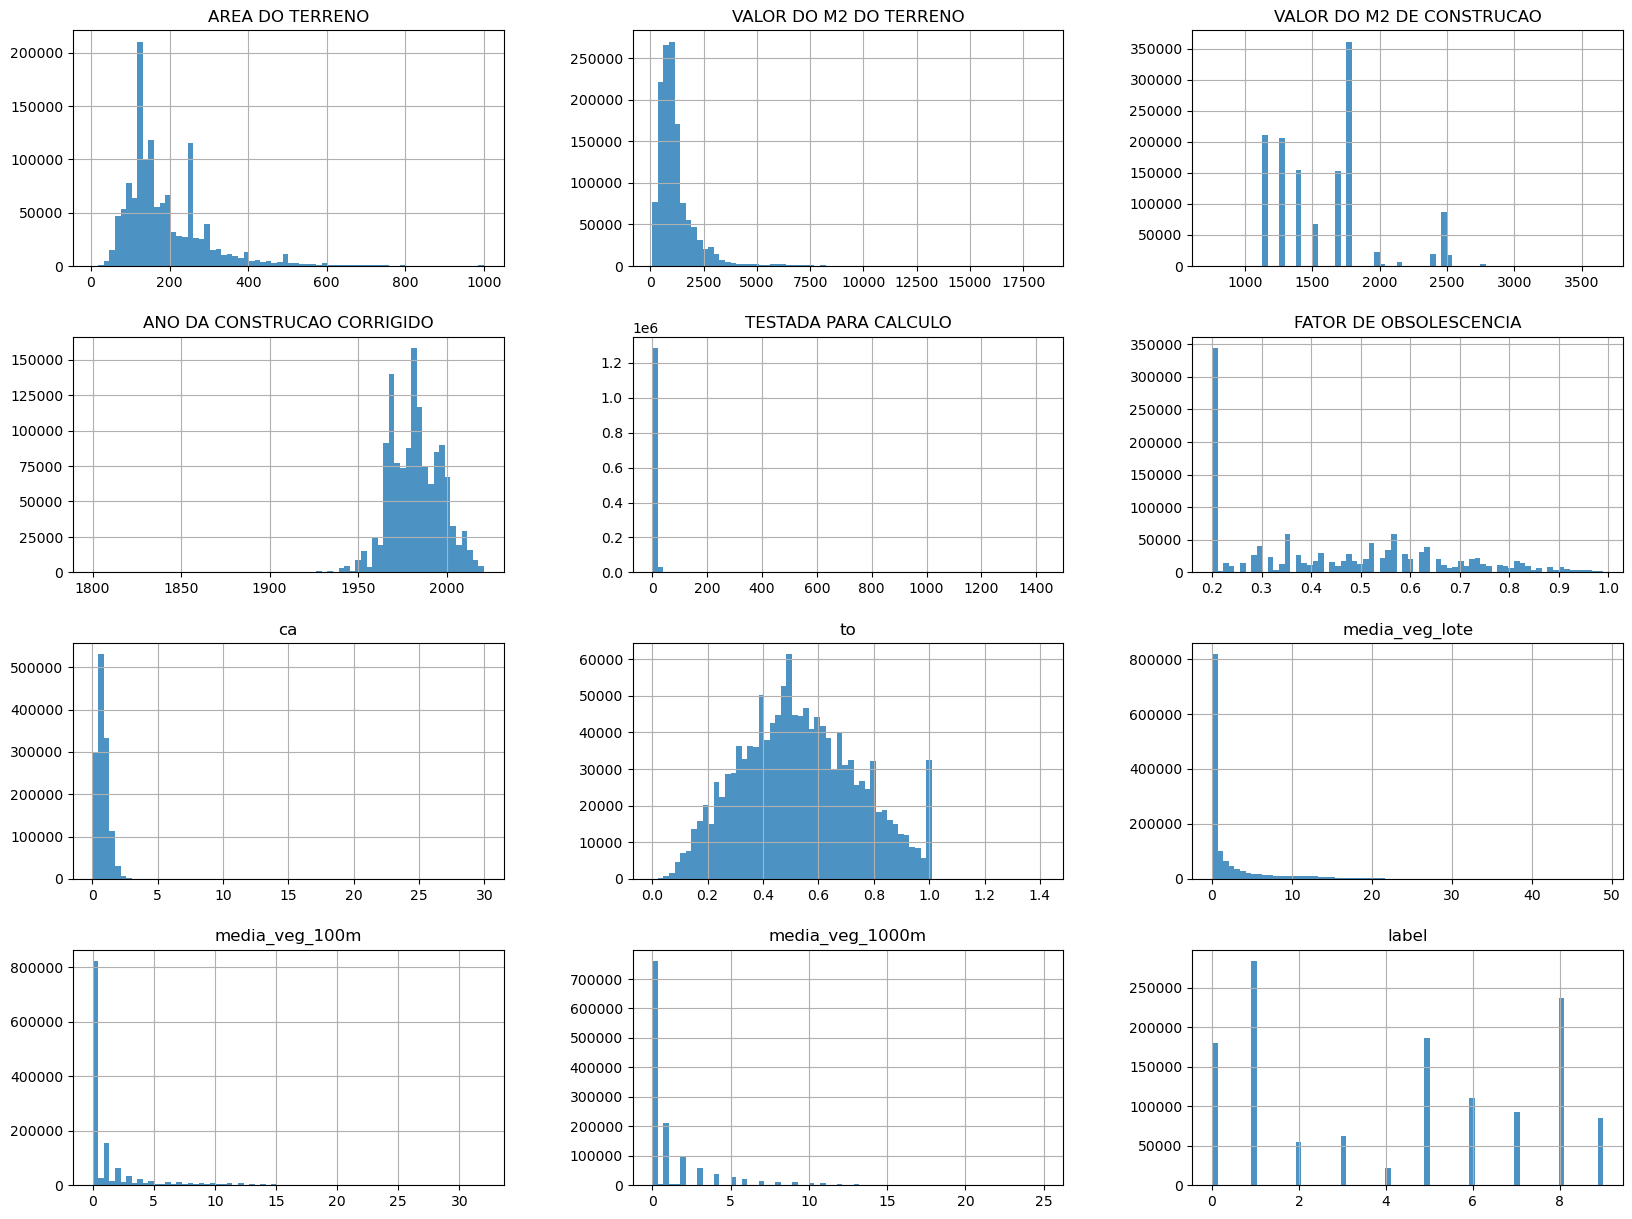

In [56]:
df_iptu.hist(bins=70, figsize=(20, 15), alpha=0.8)

In [47]:
df_iptu['label'] = clustering.labels_

In [48]:
df_dummy = pd.concat([df_iptu, pd.get_dummies(df_iptu.label)], axis=1)#.groupby(by='ds_codigo')

In [49]:
df_dummy.drop(atributos, axis=1).drop(['ds_nome', 'label'], axis=1).groupby(by='ds_codigo').sum()

,0,1,2,3,4,5,6,7,8,9
ds_codigo,,,,,,,,,,
1,485.00,8517.00,0.00,572.00,0.00,1687.00,2229.00,576.00,2468.00,89.00
10,1.00,388.00,0.00,2.00,155.00,9.00,167.00,1029.00,9.00,2.00
11,4693.00,3111.00,828.00,633.00,0.00,3586.00,2022.00,0.00,6938.00,3058.00
12,239.00,2271.00,851.00,1684.00,0.00,838.00,622.00,172.00,1064.00,2821.00
13,2172.00,1891.00,3180.00,510.00,0.00,1728.00,905.00,0.00,2858.00,1790.00
...,...,...,...,...,...,...,...,...,...,...
92,828.00,11864.00,176.00,395.00,0.00,1810.00,4875.00,0.00,3597.00,157.00
93,764.00,6833.00,0.00,609.00,0.00,3308.00,2211.00,55.00,3208.00,125.00
94,1182.00,4403.00,106.00,1266.00,0.00,2957.00,1068.00,6.00,2560.00,1290.00


In [50]:
gdf_tipologia_por_distrito = gdf_distritos.merge(df_dummy.drop(atributos, axis=1).drop(['ds_nome', 'label'], axis=1).groupby(by='ds_codigo').sum().reset_index(), left_on='ds_codigo', right_on='ds_codigo')

In [51]:
gdf_tipologia_por_distrito.columns = [str(i) for i in gdf_tipologia_por_distrito.columns]

In [52]:
gdf_tipologia_por_distrito.to_file('resultados/tipologia_por_distrito.gpkg', driver='GPKG')

In [87]:
label = 9

In [88]:
df_iptu[df_iptu.label == label].describe()

,AREA DO TERRENO,VALOR DO M2 DO TERRENO,VALOR DO M2 DE CONSTRUCAO,ANO DA CONSTRUCAO CORRIGIDO,TESTADA PARA CALCULO,FATOR DE OBSOLESCENCIA,ca,to,media_veg_lote,media_veg_100m,media_veg_1000m,label
count,85181.00,85181.00,85181.00,85181.00,85181.00,85181.00,85181.00,85181.00,85181.00,85181.00,85181.00,85181.00
mean,193.75,954.39,1505.25,1983.80,8.04,0.44,0.64,0.47,8.97,6.63,5.09,9.00
std,89.42,592.15,298.66,11.43,3.40,0.19,0.33,0.19,5.21,2.56,2.44,0.00
min,21.00,89.00,986.00,1919.00,0.00,0.20,0.02,0.01,0.00,0.00,0.00,9.00
25%,126.00,518.00,1291.00,1975.00,5.10,0.23,0.38,0.33,5.35,4.98,3.00,9.00
50%,165.00,840.00,1383.00,1983.00,7.50,0.45,0.60,0.47,9.09,6.63,5.00,9.00
75%,250.00,1218.00,1774.00,1993.00,10.00,0.57,0.87,0.60,12.16,8.34,7.00,9.00
max,964.00,5225.00,2748.00,2021.00,38.00,0.99,2.26,1.08,34.42,19.68,15.54,9.00


array([[<AxesSubplot:title={'center':'AREA DO TERRENO'}>,
        <AxesSubplot:title={'center':'VALOR DO M2 DO TERRENO'}>,
        <AxesSubplot:title={'center':'VALOR DO M2 DE CONSTRUCAO'}>],
       [<AxesSubplot:title={'center':'ANO DA CONSTRUCAO CORRIGIDO'}>,
        <AxesSubplot:title={'center':'TESTADA PARA CALCULO'}>,
        <AxesSubplot:title={'center':'FATOR DE OBSOLESCENCIA'}>],
       [<AxesSubplot:title={'center':'ca'}>,
        <AxesSubplot:title={'center':'to'}>,
        <AxesSubplot:title={'center':'media_veg_lote'}>],
       [<AxesSubplot:title={'center':'media_veg_100m'}>,
        <AxesSubplot:title={'center':'media_veg_1000m'}>,
        <AxesSubplot:title={'center':'label'}>]], dtype=object)

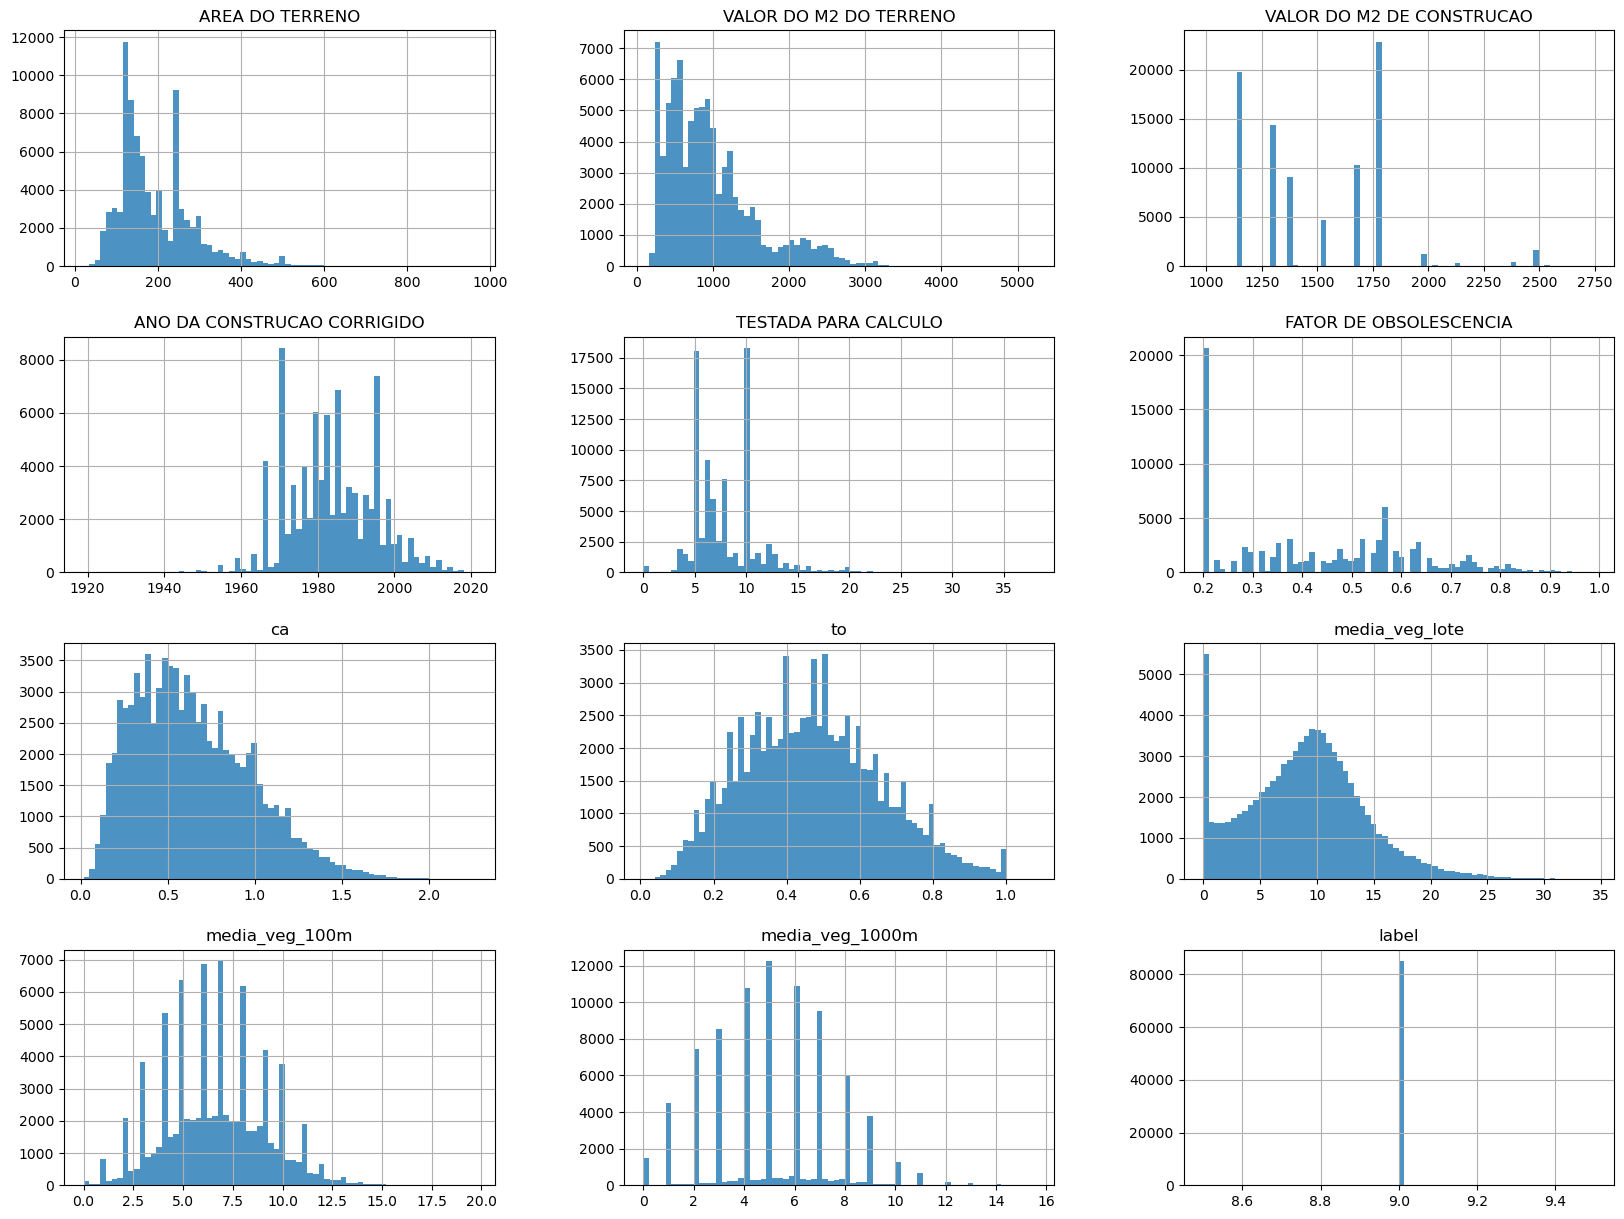

In [89]:
df_iptu[df_iptu.label == label].hist(bins=70, figsize=(20, 15), alpha=0.8)